In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import matplotlib.gridspec as gridspec 
import pickle
import nibabel as nib
from tvb.simulator.lab import *
import bct as bct
import os
import pickle

# write python dict to a file
output = open('/home/etienne/notebooks/ID_A148_to_Grandj_reduced.pkl', 'rb')
ID_A148_to_Grandj_reduced=pickle.load(output)
output.close()

path ='/home/etienne/data/Grandjean_mouse_fMRI/'
micetable=pd.read_csv(path+'participants.tsv',sep='\s+')

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]


sys.path.insert(0, '/home/etienne')
from src import analysis, simulation  # Import analysis for fcd and clustering
regions=pd.read_csv('modules.csv')
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)

regions108=regions[regions.remove_ROI==False]
regions108.index=np.arange(108)


regions108['hemisphere']=['Right']*54 + ['Left']*54
regionsorg=regions108.sort_values(by=['hemisphere','module'])

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Import the anatomical structural connectivity.
path='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(path+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [3]:
def edges_str(Bold):
    return(np.sqrt(np.sum(analysis.go_edge(Bold)**2,axis=1)))

def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def edge_to_FC(edge,n=108):
    
    #Make the Functional Connectivity matrix from an edge
    
    A=np.zeros((n,n))
    triu=np.triu_indices(n, 1)
    A[triu]=edge
    tril=(triu[1],triu[0])
    A[tril]=edge
    A[np.arange(n),np.arange(n)]=[0]*n
    return(A)

In [4]:
path='/home/etienne/data/Grandjean_mouse_fMRI/timeseries/'

bold={}
i=0
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
        bold['%d'%(i+1)]=np.loadtxt(path+filename)
    i+=1

In [5]:
indexwt=micetable[(micetable.genotype=='wild-type')&(micetable.volume==500)].index.tolist()
boldwt={}
for k in indexwt:
    boldwt[str(k)]=bold[str(k)]

In [6]:
Boldwt={}
nregions=148
regcorr=np.arange(nregions)[np.isin(np.arange(nregions),remove_roi)==False]

for j in indexwt:
    volume=bold[str(j)].shape[0]
    bd=np.zeros((volume,nregions))
    for i in range(nregions):
        bd[:,i]=boldwt['%d'%j][:,ID_A148_to_Grandj_reduced['%d'%i]]
    Boldwt['%d'%j]=bd[:,regcorr]

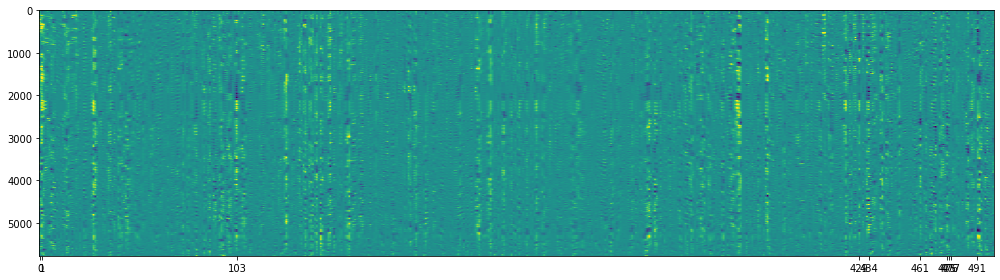

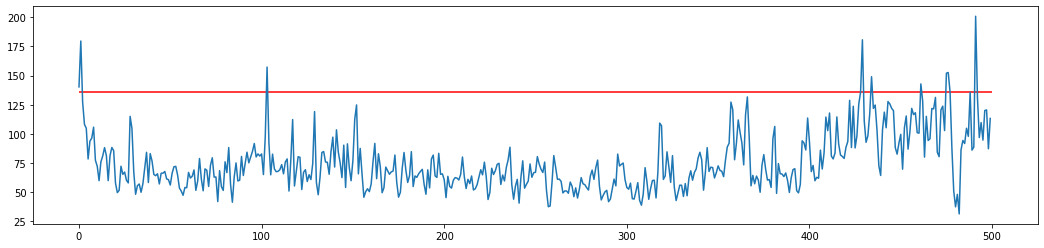

In [7]:
subject=2
B1=Boldwt[str(subject)]
volume=B1.shape[0]
constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
Edges=analysis.go_edge(B1)
eFCD=np.corrcoef(Edges)

p=np.percentile(edges_str(B1),98)
edgec=np.arange(500)[edges_str(B1)>p]

plt.figure(figsize=(14,4))
plt.imshow(Edges[:,:].T,aspect='auto', cmap='viridis',vmin=-2.5,vmax=2.5)
plt.xticks(edgec)
#plt.colorbar()

plt.tight_layout()

plt.show()
plt.figure(figsize=(18,4))
plt.plot(edges_str(B1))
plt.hlines(p,xmin=0,xmax=500,colors='r')

In [10]:
def Likelihood_activity(a,tau,M):
    n=M.shape[0]
    a=a.reshape((n,1))
    amat=np.dot(a,a.T)
    MLmat=(M - tau*amat)/(np.ones((n,n))-amat)
    MLmat[np.eye(n)==1]=0
    F=np.sum(MLmat,1)
    return(F)

def a_init(M,tau):
    n=M.shape[0]
    deg=sum(M,1)/tau
    denom=np.sqrt(np.sum(M)/tau)
    a=np.min([(deg/denom),0.999*np.ones((n))],0)
    return(a)

In [11]:
Boldwt.keys()

dict_keys(['2', '18', '19', '33', '39', '40', '41', '42', '47', '48', '49', '50', '54', '55', '56', '57', '58', '59', '60', '61', '62', '76', '81', '82', '83', '84', '85', '86', '99', '100', '101', '103', '104', '105', '112', '113', '114', '115', '116', '117', '118', '123', '124', '125', '126', '127', '128', '129', '130', '138', '139', '142', '144', '145', '146', '149', '150', '155', '156', '158', '159', '160', '163', '164', '166', '168'])

In [371]:
subject=19
B1=Boldwt[str(subject)]
volume=B1.shape[0]
constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
Edges=analysis.go_edge(B1)

threshold=10*np.median(np.abs(Edges))
Edges_bin=np.zeros(shape=Edges.shape)

Edges_bin[np.abs(Edges)>threshold]=1
FCbin=edge_to_FC(np.sum(Edges_bin,0))

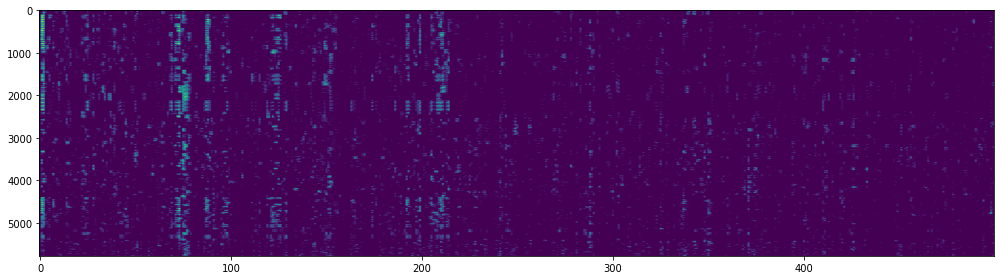

In [372]:
plt.figure(figsize=(14,4))
plt.imshow(Edges_bin[:,:].T,aspect='auto', cmap='viridis',vmin=0,vmax=1)
plt.tight_layout()
plt.show()

In [373]:
np.mean(Edges_bin)

0.015443059882312218

In [127]:
from scipy.optimize import fsolve,root
from scipy.stats import binom

def backbone(FCbin,tau,alpha=5*1e-2):
    cl=1-alpha
    n=FCbin.shape[0]
    def func(x):
        return(Likelihood_activity(x,tau=500,M=FCbin))

    a_i=a_init(FCbin,500)
    a_opt=fsolve(func,x0=a_i,epsfcn=1e-5)
    a=a_opt.reshape((n,1))
    amat=np.dot(a,a.T)

    pvalmat=binom.ppf(np.ones(FCbin.shape)*cl,np.ones(FCbin.shape)*tau,amat)
    backbone=np.where(FCbin>pvalmat)
    return(backbone)

def jaccard_index(back1,back2):
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.sum(Bmatint>0)
    return(jaccard)

def Jac_alt(back1,back2):
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1
    a1=np.sum(Bmat1>0)
    a2=np.sum(Bmat2>0)

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.min([a1,a2])
    return(jaccard)

In [426]:
Backbones=[]
alpha=5e-2
factor=9

for subject in Boldwt.keys():
    B1=Boldwt[subject]
    volume=B1.shape[0]
    constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

    B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
    Edges=analysis.go_edge(B1)

    threshold=factor*np.median(np.abs(Edges))
    Edges_bin=np.zeros(shape=Edges.shape)

    Edges_bin[np.abs(Edges)>threshold]=1
    FCbin=edge_to_FC(np.sum(Edges_bin,0))
    
    b=backbone(FCbin,500,alpha=alpha)
    Backbones.append(b)

In [427]:
b_len=[]
for i in range(len(Backbones)):
    b_len.append(Backbones[i][0].shape[0])

In [428]:
np.quantile(b_len,[0.25,0.5,0.75])

array([352.5, 415. , 540. ])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe844d54df0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe844d24460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe844d548e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe844d24f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe844d361c0>],
 'means': []}

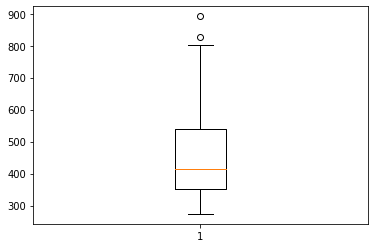

In [429]:
plt.boxplot(b_len)

In [430]:
p=len(Backbones)
Jacmat=np.zeros((p,p))
for i in range (p):
    for j in range(p):
        Jacmat[j,i]=jaccard_index(Backbones[i],Backbones[j])

In [431]:
p=len(Backbones)
Jacmatalt=np.zeros((p,p))
for i in range (p):
    for j in range(p):
        Jacmatalt[j,i]=Jac_alt(Backbones[i],Backbones[j])

<AxesSubplot:>

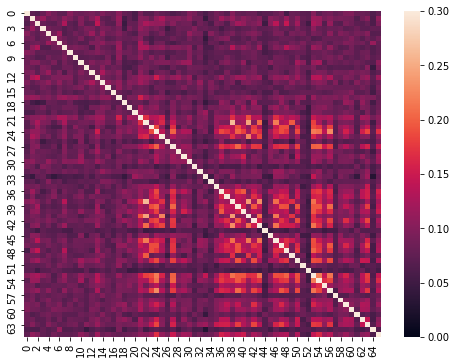

In [438]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(Jacmat,vmin=0,vmax=0.3)

<AxesSubplot:>

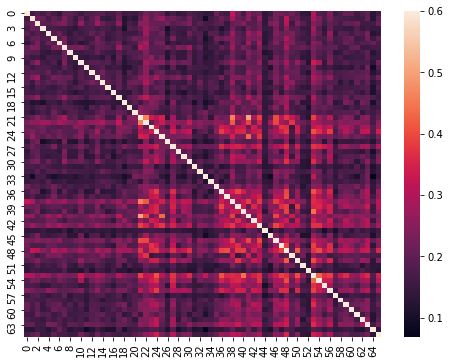

In [433]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(Jacmatalt,vmax=0.6)

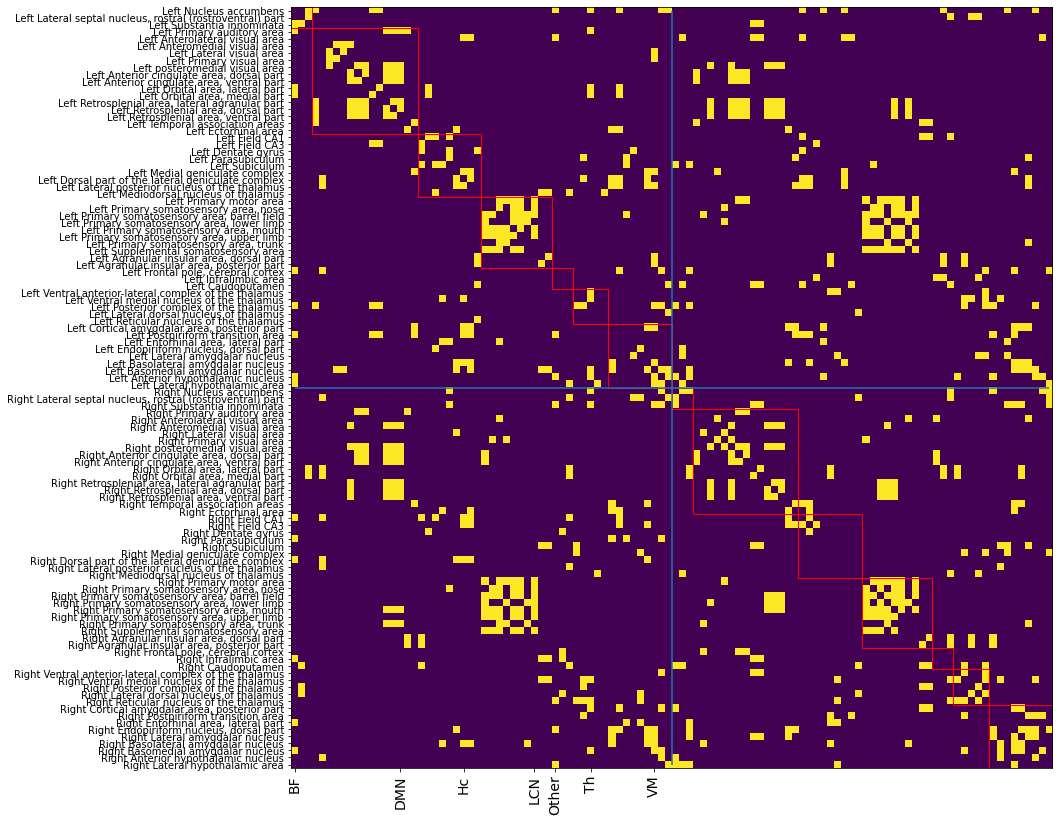

In [434]:
mouse=np.random.randint(low=0,high=66)

Bmat=np.zeros((n,n))
Bmat[Backbones[mouse]]=1
test=Bmat[index,:][:,index]

plt.figure(figsize=(14,14))
plt.imshow(test)
plt.yticks(range(0, n), regionsorg.regions, fontsize=10, rotation=0)
plt.xticks(np.cumsum(l)-3, np.unique(regionsorg.module), fontsize=14, rotation=90)

plt.hlines(y=53.5,xmin=0,xmax=107)
plt.vlines(x=53.5,ymin=0,ymax=107)

l=regionsorg.groupby('module').nunique().regions/2

center=0
for i in range(len(l)):
    rectl=plt.Rectangle((center-0.5,center-0.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectl)
    rectr=plt.Rectangle((center+53.5,center+53.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectr)
    center+=l[i]

plt.show()

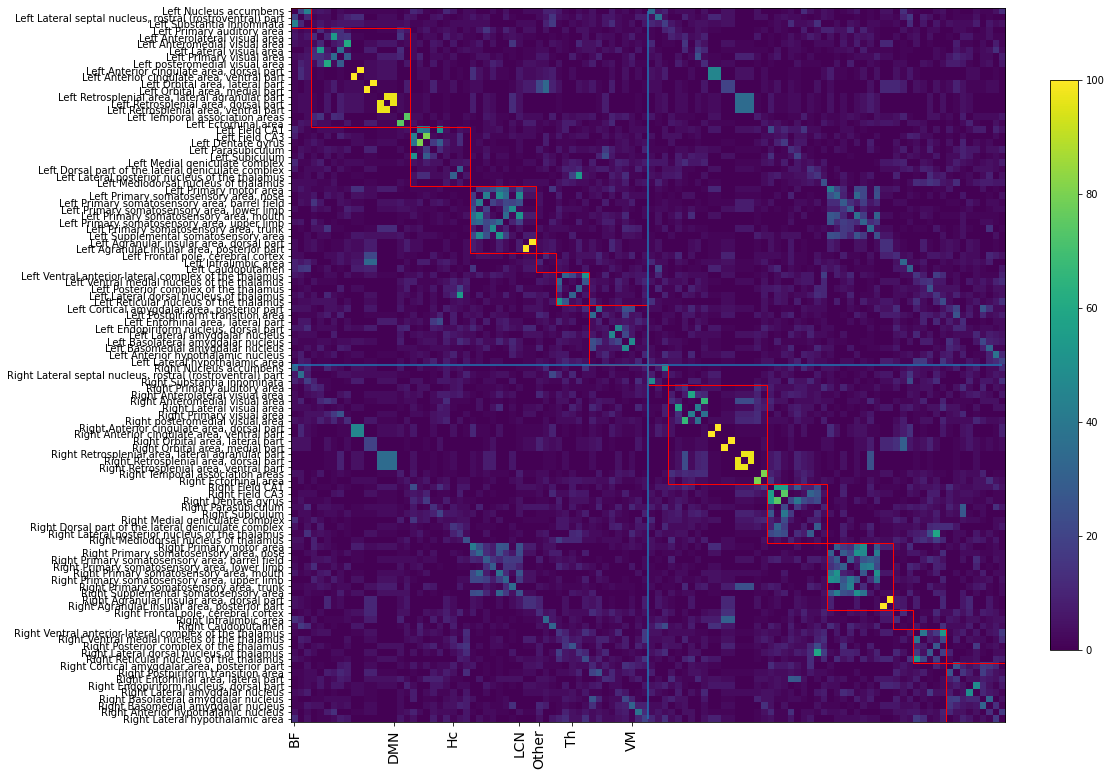

In [437]:
Bagg=np.zeros((n,n))
for k in range(66):  
    mouse=np.random.randint(low=0,high=66)
    Bmat=np.zeros((n,n))
    Bmat[Backbones[mouse]]=1
    test=Bmat[index,:][:,index]
    Bagg+=test
    
    
Bagg=Bagg*100/66
Bagg[Bagg<0]=0


plt.figure(figsize=(16,14))
plt.imshow(Bagg)
plt.yticks(range(0, n), regionsorg.regions, fontsize=10, rotation=0)
plt.xticks(np.cumsum(l)-3, np.unique(regionsorg.module), fontsize=14, rotation=90)

plt.hlines(y=53.5,xmin=0,xmax=107)
plt.vlines(x=53.5,ymin=0,ymax=107)


l=regionsorg.groupby('module').nunique().regions/2
center=0
for i in range(len(l)):
    rectl=plt.Rectangle((center-0.5,center-0.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectl)
    rectr=plt.Rectangle((center+53.5,center+53.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectr)
    center+=l[i]

plt.colorbar(shrink=0.75)
plt.show()